In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import functions as fc

df = pd.read_csv("/work/aavocone/large_set.csv")


#test train split
X = df[df.columns[:-3]]    #exclude "signal" "classification" "B_sig_isSignalAcceptMissingNeutrino"
y = df["signal"]            
xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5)

model50 = xgb.XGBClassifier()
model50.load_model("/work/aavocone/models/model50.txt")
y50_train = model50.predict_proba(xtrain)[:,1]
y50 = model50.predict_proba(xtest)[:,1]

model100 = xgb.XGBClassifier()
model100.load_model("/work/aavocone/models/model100.txt")
y100_train = model100.predict_proba(xtrain)[:,1]
y100 = model100.predict_proba(xtest)[:,1]

model200 = xgb.XGBClassifier()
model200.load_model("/work/aavocone/models/model200.txt")
y200_train = model200.predict_proba(xtrain)[:,1]
y200 = model200.predict_proba(xtest)[:,1]

model500 = xgb.XGBClassifier()
model500.load_model("/work/aavocone/models/model500.txt")
y500_train = model500.predict_proba(xtrain)[:,1]
y500 = model500.predict_proba(xtest)[:,1]


#efficiency
sh50_train,bh50_train,s50_train,b50_train,bin_edges = fc.efficiency(y50_train,ytrain)
sh50,bh50,s50,b50,bin_edges = fc.efficiency(y50,ytest)

sh100_train,bh100_train,s100_train,b100_train,bin_edges = fc.efficiency(y100_train,ytrain)
sh100,bh100,s100,b100,bin_edges = fc.efficiency(y100,ytest)

sh200_train,bh200_train,s200_train,b200_train,bin_edges = fc.efficiency(y200_train,ytrain)
sh200,bh200,s200,b200,bin_edges = fc.efficiency(y200,ytest)

sh500_train,bh500_train,s500_train,b500_train,bin_edges = fc.efficiency(y500_train,ytrain)
sh500,bh500,s500,b500,bin_edges = fc.efficiency(y500,ytest)


/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


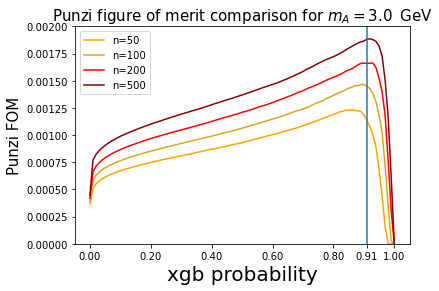

In [12]:
#ponzi
def PFOM(seff,beff,bhist,n):
    return seff/(np.sqrt(beff*sum(bhist))+n/2)

bin_edges = np.linspace(0,1,101)

plt.plot(bin_edges, PFOM(s50,b50,bh50,5), label = "n=50", color ="orange")
plt.plot(bin_edges, PFOM(s100,b100,bh100,5), label = "n=100", color ="goldenrod")
plt.plot(bin_edges, PFOM(s200,b200,bh200,5), label = "n=200", color ="red")
plt.plot(bin_edges, PFOM(s500,b500,bh500,5), label = "n=500", color ="darkred")
plt.plot([0.91,0.91],[0,0.002],color="tab:blue")
plt.title("Punzi figure of merit comparison for $m_A = 3.0\:$ GeV",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.ylim(0,0.002)
plt.xlabel("xgb probability", fontsize = 20)
plt.xticks([0,0.2,0.4,0.6,0.8,0.91,1.0])
plt.legend()
plt.savefig(f"/work/aavocone/week5/large_PFOM3.pdf", format="pdf",bbox_inches="tight")
plt.show()

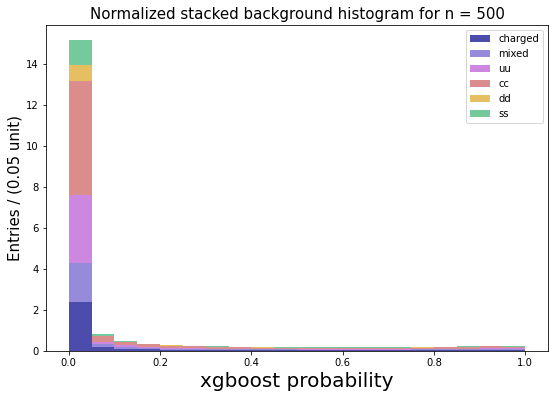

In [4]:
fc.stacked_hist(df,y500,ytest,"/work/aavocone/week5/stacked_hist_n500.pdf",np.linspace(0,1,21))


## Pfom of different n for $m_A = 3.0$ GeV

/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


---------------------------------------------------------------------
Sample: 3_0_141
Background pre cut : 139016278.0
Background post cut: 489501
Number of sensitivity events: 0.11
Sensitivity: 2.17e-07 sigma
---------------------------------------------------------------------
Sample: 3_0_500
Background pre cut : 139016278.0
Background post cut: 96304
Number of sensitivity events: 0.23
Sensitivity: 2.44e-06 sigma


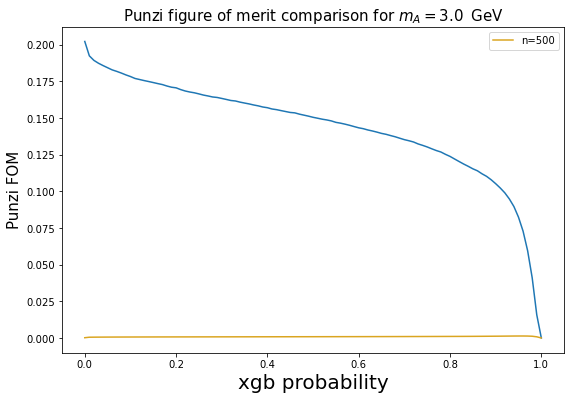

0.07287072870728707


In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import functions as fc


#ponzi
def PFOM(seff,beff,bhist,n):
    return seff/(np.sqrt(beff*sum(bhist))+n/2)

def sensitivity(pfom_max,B_events):

    bf = 2*0.514*4.6e-6
    sigma=1.11e6 #fb
    l=100/3 #fb⁻¹
    ns=bf*sigma*l*pfom_max
    print(f"Number of sensitivity events: {ns:.2}")
    return ns/B_events


df = pq.read_table("/ceph/aavocone/Datasets/3_large.parquet")
df = df.to_pandas()

X = df[df.columns[:-1]]    #exclude "signal" "classification" "B_sig_isSignalAcceptMissingNeutrino"
y = df["signal"]   
xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5)


test_model = ["3_0_141","3_0_500","u3_503","o3_141"]
pfom = []
S_list = []

for model in test_model:
    clf = xgb.XGBClassifier()
    clf.load_model(f"/work/aavocone/models/{model}.txt")

    yprob = clf.predict_proba(xtrain)[:,1]
    sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytrain,eff_type=0)
    p = fc.PFOM(s,b,bh,5)
    pfom.append(p)
    max_index = np.where(p==max(p))[0][0]
    b_max = bh >= max_index/100
    b_max = b_max[b_max!=0]
    print("---------------------------------------------------------------------")
    print("Sample:", model)
    print("Background pre cut :", len(y)-sum(y))
    print("Background post cut:", len(b_max))
    S = sensitivity(p[max_index],len(b_max))
    S_list.append(S)
    print(f"Sensitivity: {S:.3} sigma")



bin_edges = np.linspace(0,1,101)

plt.figure(figsize=(9,6))
plt.plot(bin_edges, pfom[0], label = "n=141", color ="orange")
plt.plot(bin_edges, pfom[1], label = "n=500", color ="goldenrod")
plt.plot(bin_edges, pfom[2], label = "n=under 503", color ="red")
plt.plot(bin_edges, pfom[2], label = "n= oover 141", color ="darkred")
plt.title("Punzi figure of merit comparison for $m_A = 3.0\:$ GeV",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
plt.show()



In [4]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import functions as fc


#ponzi
def PFOM(seff,beff,bhist,n):
    return seff/(np.sqrt(beff*sum(bhist))+n/2)

def sensitivity(pfom_max,B_events):

    bf = 2*0.514*4.6e-6
    sigma=1.11e6 #fb
    l=100/3 #fb⁻¹
    ns=bf*sigma*l*pfom_max
    print(f"Number of sensitivity events: {ns:.2}")
    return ns/B_events


df = pq.read_table("/ceph/aavocone/Datasets/4_large.parquet")
df = df.to_pandas()

X = df[df.columns[:-1]]    #exclude "signal" "classification" "B_sig_isSignalAcceptMissingNeutrino"
y = df["signal"]   
xtrain,xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.33, stratify = y)
xtrain,xval,ytrain,yval = train_test_split(xtrain, ytrain, test_size = 0.5)


test_model = ["new_4_6_model500","new_4_6_model800"]
pfom = []
S_list = []

for model in test_model:
    clf = xgb.XGBClassifier()
    clf.load_model(f"/work/aavocone/models/{model}.txt")

    yprob = clf.predict_proba(xtrain)[:,1]
    sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytrain,eff_type=0)
    p = fc.PFOM(s,b,bh,5)
    pfom.append(p)
    max_index = np.where(p==max(p))[0][0]
    b_max = bh >= max_index/100
    b_max = b_max[b_max!=0]
    print("---------------------------------------------------------------------")
    print("Sample:", model)
    print("Background pre cut :", len(y)-sum(y))
    print("Background post cut:", len(b_max))
    S = sensitivity(p[max_index],len(b_max))
    S_list.append(S)
    print(f"Sensitivity: {S:.3} sigma")



bin_edges = np.linspace(0,1,101)

plt.figure(figsize=(9,6))
plt.plot(bin_edges, pfom[0], label = "n=141", color ="orange")
plt.plot(bin_edges, pfom[1], label = "n=500", color ="goldenrod")
plt.plot(bin_edges, pfom[2], label = "n=under 1000", color ="red")
plt.plot(bin_edges, pfom[2], label = "n=over 1000", color ="darkred")
plt.title("Punzi figure of merit comparison for $m_A = 3.0\:$ GeV",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend()
plt.show()

array([0.00071577, 0.00200115, 0.00212219, 0.00220181, 0.00226348,
       0.0023097 , 0.00235359, 0.00238929, 0.00242188, 0.00245331,
       0.00248149, 0.00250522, 0.00253149, 0.00255619, 0.00257879,
       0.00259937, 0.00261748, 0.0026377 , 0.0026575 , 0.00267708,
       0.0026941 , 0.00270991, 0.00272814, 0.00274511, 0.00275981,
       0.00277253, 0.00279119, 0.00280645, 0.00281889, 0.00282964,
       0.00284496, 0.00286155, 0.00287525, 0.00289026, 0.0029021 ,
       0.00291037, 0.00292539, 0.0029373 , 0.00295418, 0.00296777,
       0.00298126, 0.00299282, 0.00300369, 0.00301611, 0.00303131,
       0.00304028, 0.0030535 , 0.00306784, 0.00307832, 0.00309353,
       0.00310511, 0.00312012, 0.00313291, 0.00314212, 0.00315496,
       0.00317027, 0.00318395, 0.00319633, 0.00321423, 0.00322826,
       0.00323952, 0.00325633, 0.00326957, 0.00328768, 0.00330685,
       0.00332358, 0.00334084, 0.00335666, 0.00336907, 0.00338872,
       0.00340813, 0.00342735, 0.00344252, 0.00345976, 0.00348